In [4]:
from openai import OpenAI
import ollama

api_key_dict = {
    "moonshot-v1-8k": "sk-vcqUlecm5zTpg1N4BWVBlLw3FKW5KzlvAsAuHt225zzS6V1Z", 
    "glm-4": "013b03f75c20632d7188630e2fcad08c.VB00O7KcrwyKd14T"}
base_url_dict = {
    "moonshot-v1-8k": "https://api.moonshot.cn/v1",
    "glm-4": "https://open.bigmodel.cn/api/paas/v4/"
    }


In [5]:
# prompt settings

system_prompt = "You are an expert of sentiment and opinion analysis."

def prompt_direct_inferring(context, target):
    new_context = f'Given the sentence "{context}", '
    prompt = f"""{new_context} what is the sentiment polarity towards {target}? """
    return new_context, prompt


def prompt_for_aspect(context, target):
    new_context = f'Given the sentence "{context}", '
    prompt = f"""{new_context} which specific aspect of {target} is possibly mentioned? 
    Answer briefly without explanation.
    """
    return new_context, prompt


def prompt_for_opinion(context, target, aspect_expr):
    new_context = f"{context} and the mentioned aspect is about {aspect_expr}."
    prompt = f""" {new_context} 
    Based on the common sense, what is the implicit opinion towards the mentioned aspect of {target}, and why? 
    Answer briefly without explanation.
    """
    return new_context, prompt


def prompt_for_polarity(context, target, opinion_expr):
    new_context = f"{context} The opinion towards the mentioned aspect of {target} is: {opinion_expr}."
    prompt = f""" {new_context} 
    Based on such opinion, what is the sentiment polarity towards {target}?
    Return only one of the sentiment polarity words: [positive, neutral, negative]
    """
    return new_context, prompt


# def prompt_for_polarity_label(context, polarity_expr):
#     prompt = f""" {context} The sentiment polarity is {polarity_expr}.
#     Based on these contexts, summarize and return only one of the sentiment polarity words: [positive, neutral, negative]"""
#     return prompt


In [6]:
# config

import yaml
import os

config = yaml.load(open("config.yaml", 'r'), Loader=yaml.FullLoader)
model_path = config['model_path']
output_path = config['output_path']

label_list = config['label_list']
label_dict = config['label_dict']
sentiment_type = config['sentiment_type']


In [7]:
# load data

import pickle as pkl
import pandas as pd

def load_data(data_fname):
    data_path = os.path.join(config['data_path'], data_fname)
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file {data_path} not found.")
    elif data_path.endswith('.csv'):
        data = pd.read_csv(data_path)
        data.rename(columns={"raw_texts": "sentence", "raw_aspect_terms": "target", "labels": "label", "implicits": "implicit"}, inplace=True)
        data = data[["sentence", "target", "label", "implicit", "source"]]
    elif data_path.endswith('.pkl'):
        data = pkl.load(open(data_path, 'rb'))
        data = pd.DataFrame(data, columns=["sentence", "target", "label", "implicit"])
    return data




In [8]:
# get llm response

def get_llm_response(conversation, prompt_text, model_name='llama3.1'):
    
    conversation.append(
        {'role': 'user', "content": prompt_text}
    )
    
    if model_name.startswith("llama"):
        response = ollama.chat(model=model_name, messages=conversation)
        content = response['message']['content']
        
    else:
        client = OpenAI(
            api_key=api_key_dict[model_name], 
            base_url=base_url_dict[model_name], 
        )
        completion = client.chat.completions.create(
            model = model_name,
            messages=conversation,
        )
        content = completion.choices[0].message.content
        
    conversation.append(
        {"role": "assistant", "content": content}
    )
    
    result = content.replace('\n', ' ').strip()
    return conversation, result

def direct_inference(text, target, model_name):
    
    conversation = [{'role': 'system', "content": system_prompt}]
    
    context_step1, prompt_step1 = prompt_direct_inferring(text, target)
    conversation, output_lb = get_llm_response(conversation, prompt_step1, model_name)
    
    output_lb = output_lb.lower().strip()
    output = 2
    for k, lb in enumerate(label_list):
        if lb in output_lb: output = k; break
    
    return conversation, output


# whole process

def cot_inference(text, target, model_name):
    
    conversation = [{'role': 'system', "content": system_prompt}]
    
    # step 1: aspect inferring
    context_step1, prompt_step1 = prompt_for_aspect(text, target)
    conversation, aspect_expr = get_llm_response(conversation, prompt_step1, model_name)

    # step 2: opinion inferring
    context_step2, prompt_step2 = prompt_for_opinion(context_step1, target, aspect_expr)
    conversation, opinion_expr = get_llm_response(conversation, prompt_step2, model_name)

    # step 3: polarity inferring
    # context_step3, prompt_step3 = prompt_for_polarity(context_step2, target, opinion_expr)
    # conversation, polarity_expr = get_llm_response(conversation, prompt_step3, model_name)

    # get polarity label
    # prompt_getlabel = prompt_for_polarity_label(context_step3, polarity_expr)
    # conversation, output_lb = get_llm_response(conversation, prompt_getlabel, model_name)
    
    context_step3, prompt_step3 = prompt_for_polarity(context_step2, target, opinion_expr)
    conversation, output_lb = get_llm_response(conversation, prompt_step3, model_name)
    
    # get the output label
    output_lb = output_lb.lower().strip()
    output = 2
    for k, lb in enumerate(label_list):
        if lb in output_lb: output = k; break
    
    # convert the conversation dict to text list
    # conversation_text = []
    # for i in range(len(conversation)):
    #     role = conversation[i]['role']
    #     content = conversation[i]['content']
    #     # remove "Answer briefly without explanation." in content
    #     content = content.replace("Answer briefly without explanation.", "").strip()
    #     conversation_text.append(f"{role}: {content}")
    
    return conversation, output
    

In [9]:
# data_fname = "laptops_base_google-flan-t5-base.pkl"
# data_fname = "restaurants_base_google-flan-t5-base.pkl"
# data_fname = "Implicit_Labeled_data_for_finetune.csv"
data_fname = "Implicit_Labeled_data_for_test.csv"
data = load_data(data_fname)
data

,sentence,target,label,implicit,source
0,"boot time is super fast, around anywhere from ...",Boot time,0,0,laptops
1,tech support would not fix the problem unless ...,tech support,1,0,laptops
2,set up was easy.,Set up,0,0,laptops
3,did not enjoy the new windows 8 and touchscree...,Windows 8,1,0,laptops
4,did not enjoy the new windows 8 and touchscree...,touchscreen functions,1,0,laptops
...,...,...,...,...,...
1747,"creamy appetizers--taramasalata, eggplant sala...",Creamy appetizers,0,0,restaurants
1748,"creamy appetizers--taramasalata, eggplant sala...",warm pitas,2,0,restaurants
1749,"creamy appetizers--taramasalata, eggplant sala...",taramasalata,0,0,restaurants
1750,"creamy appetizers--taramasalata, eggplant sala...",eggplant salad,0,0,restaurants


In [ ]:
# direct inference

infer_type = "direct"
preds = []
reasoning_texts = []
# model_name = "glm-4"
model_name = "llama3.2"
error_rows = []

for i, row in data.iterrows():
    try:
        reasoning_text, pred = direct_inference(row['sentence'], row['target'], model_name)
    except Exception as e:
        print(f"Error in row {i}: {e}")
        error_rows.append(i)
        reasoning_text, pred = [], 2
    preds.append(pred)
    reasoning_texts.append(reasoning_text)
    
result = data.copy()
result['pred'] = preds
result['reasoning'] = reasoning_texts
# save the result
result.to_csv(os.path.join(output_path, f"output_{data_fname.split('.')[0]}_{model_name}_{infer_type}.csv"), index=False)


In [ ]:
# cot inference

preds = []
reasoning_texts = []
# model_name = "glm-4"
model_name = "llama3.1"
error_rows = []

for i, row in data.iterrows():
    try:
        reasoning_text, pred = cot_inference(row['sentence'], row['target'], model_name)
    except Exception as e:
        print(f"Error in row {i}: {e}")
        error_rows.append(i)
        reasoning_text, pred = [], 2
    preds.append(pred)
    reasoning_texts.append(reasoning_text)
    
result = data.copy()
result['pred'] = preds
result['reasoning'] = reasoning_texts
# save the result
result.to_csv(os.path.join(output_path, f"output_{data_fname.split('.')[0]}_{model_name}.csv"), index=False)


In [199]:
from sklearn.metrics import accuracy_score, f1_score

# evaluate the result (all, and explicit only, and implicit only)

def evaluate_result(result):
    acc = accuracy_score(result['label'], result['pred'])
    f1 = f1_score(result['label'], result['pred'], average='macro')
    return acc, f1

acc, f1 = evaluate_result(result)
print(f"Accuracy: {acc:.3f}, F1: {f1:.3f}")

acc_esa, f1_esa = evaluate_result(result[result['implicit'] == 0])
print(f"Accuracy (explicit only): {acc_esa:.3f}, F1 (explicit only): {f1_esa:.3f}")

acc_ima, f1_ima = evaluate_result(result[result['implicit'] == 1])
print(f"Accuracy (implicit only): {acc_ima:.3f}, F1 (implicit only): {f1_ima:.3f}")

with open(os.path.join(output_path, f"acc_{data_fname.split('.')[0]}_{model_name}.txt"), 'w') as f:
    f.write(f"Accuracy: {acc:.3f}, F1: {f1:.3f}\n")
    f.write(f"Accuracy (explicit only): {acc_esa:.3f}, F1 (explicit only): {f1_esa:.3f}\n")
    f.write(f"Accuracy (implicit only): {acc_ima:.3f}, F1 (implicit only): {f1_ima:.3f}\n")



Accuracy: 0.781, F1: 0.605
Accuracy (explicit only): 0.890, F1 (explicit only): 0.650
Accuracy (implicit only): 0.453, F1 (implicit only): 0.442


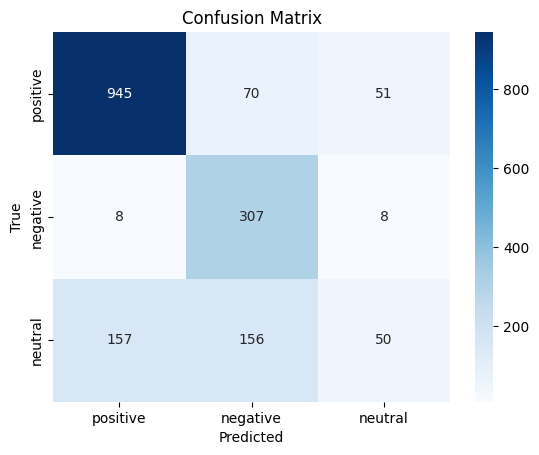

In [194]:
# confusion matrix of result

from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

cm = confusion_matrix(result['label'], result['pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [107]:
def conversion(test):
    test = test[1:]
    for i in range(len(test)):
        test[i] = test[i].replace("\n", "").strip()

    # convert text list to string
    test = '\n'.join(test)
    return test

incorrect = result[result['label'] != result['pred']]
incorrect['reasoning'] = incorrect['reasoning'].apply(lambda x: conversion(x))
incorrect.to_csv(os.path.join(output_path, f"incorrect_{data_fname.split('.')[0]}.csv"), index=False)

/var/folders/gl/bjvjzmt13dzgvftlrd57gnv40000gn/T/ipykernel_29257/1520649097.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect['reasoning'] = incorrect['reasoning'].apply(lambda x: conversion(x))
